# TABULAR EMBEDDINGS

In [1]:

import pandas as pd
import scikitplot as skplt
import torch
from ignite.engine import (
    Events,
    create_supervised_evaluator,
    create_supervised_trainer,
)
from ignite.metrics import CategoricalAccuracy, Loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelBinarizer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

In [2]:
def process_train(df, cat_columns, num_columns, target):
    
    encoders = {c: LabelEncoder() for c in cat_columns}
    scalers = {c: MinMaxScaler() for c in num_columns}
    
    df = df[target + cat_columns + num_columns]

    df_train, df_val = train_test_split(df, train_size=0.8)

    for cat_column in cat_columns:
        df[cat_column] = encoders[cat_column].fit_transform((df[cat_column]))
        
    for cat_column in cat_columns:
        df_train[cat_column] = encoders[cat_column].transform((df_train[cat_column]))
        
    for cat_column in cat_columns:
        df_val[cat_column] = encoders[cat_column].transform((df_val[cat_column]))     
        
    for num_column in num_columns:
        df_train[num_column] = scalers[num_column].fit_transform(df_train[num_column].values.reshape(-1,1))\
    
    for num_column in num_columns:
        df_val[num_column] = scalers[num_column].transform(df_val[num_column].values.reshape(-1,1))
        
    target_binarizer = LabelBinarizer()
    df_train[target] = target_binarizer.fit_transform(df_train[target])
    df_val[target] = target_binarizer.transform(df_val[target])
    embedding_dict = {cat_column: df[cat_column].unique().shape[0] for cat_column in cat_columns}
    
    return df_train, df_val, embedding_dict, encoders, scalers

In [3]:
class TabEmbedModel(nn.Module):
    def __init__(self,out_features=1, n_num_column=1, embedding_dict={}):
        super(TabEmbedModel, self).__init__()
    
        self.out_features = out_features
        embdding_output_sizes = sum([v // 2 for  v in embedding_dict.values()])

        total_dens_layers = n_num_column + embdding_output_sizes
        
        for embed, value in embedding_dict.items():
            setattr(self, embed, nn.Embedding(value, value // 2))
        
        self.layers = nn.Sequential(
            nn.Linear(total_dens_layers, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100,100),
            nn.Linear(100, self.out_features)
        
        )
        
      
    def forward(self, X):  
        num_x, cat_x = X
        embeddings_collect = []

        for i, c in enumerate(embedding_dict):
            embed = getattr(self, c)(cat_x[:, i])
            embeddings_collect.append(embed)
            
        embeddings_cat = torch.cat(embeddings_collect, dim=1).float()
        X = torch.cat([num_x, embeddings_cat], dim=1)
        ypred = self.layers(X)
        
        return ypred.float()

# Creating the Dataset Class

In [4]:
class TabDataset(Dataset):
    def __init__(self, df, cat_columns, num_columns, target_column):
        self.df = df
        self.cat_columns = cat_columns
        self.num_columns = num_columns
        self.target_column = target_column
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        
        row = self.df.iloc[ix]
        

        cat_values = torch.from_numpy(row[self.cat_columns].values)
        num_values = torch.from_numpy(row[self.num_columns].values.astype(float))
        target = torch.from_numpy(row[[self.target_column]].values)
        
        return num_values, cat_values, target 
      
    def collate_func(self, batch):
        num = torch.stack([n[0] for n in batch], dim=0).float()
        cat = torch.stack([n[1] for n in batch], dim=0).long()
        target = torch.stack([n[2] for n in batch], dim=0)
        
        return (num, cat), target.float()

In [5]:
BATCH_SIZE = 256
LR = 2e-3

df = pd.read_csv('data/adult.csv', dtype={'age':int, 
                                          'education':'category',
                                          'native.country': 'category',
                                          'income':object,
                                          'capital.loss': float,
                                         })
# 
df = df.rename(columns={c: c.replace('.', '-') for c in df.columns if '.' in c})
target = ['income']
cat_columns = ['education',
               'native-country',
               'marital-status',
               'occupation',
               'race',
               'gender',
               'capital-gain',
               'workclass',
               'relationship',
               'educational-num',
              ]

num_columns = ['capital-loss',
               'age',
               'fnlwgt',
               'hours-per-week',
              ]


df_train, df_val, embedding_dict, encoders, scalers = process_train(df, cat_columns, num_columns, target)

model = TabEmbedModel(1, n_num_column=len(num_columns), embedding_dict=embedding_dict)
model = model.cuda()

ds = TabDataset(df_train, cat_columns, num_columns, 'income')
dsval = TabDataset(df_val, cat_columns, num_columns, 'income')

dltrain = DataLoader(ds, batch_size=BATCH_SIZE, 
                     collate_fn=ds.collate_func, 
                     shuffle=True, drop_last=False)

dlval = DataLoader(dsval, batch_size=BATCH_SIZE, 
                   collate_fn=ds.collate_func, 
                   shuffle=True, drop_last=False)



optimizer = Adam(model.parameters(), lr=LR)
loss = BCEWithLogitsLoss()
trainer = create_supervised_trainer(model, optimizer, loss, device='cuda')


/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [6]:
# this shows us how many categories are there for each of the categorical-variables.
# its important as we need to know how big our embedding matrix has to be.
embedding_dict

{'education': 16,
 'native-country': 42,
 'marital-status': 7,
 'occupation': 15,
 'race': 5,
 'gender': 2,
 'capital-gain': 123,
 'workclass': 9,
 'relationship': 6,
 'educational-num': 16}

In [7]:

def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.round(y_pred)
    return y_pred, y.long()

acc = CategoricalAccuracy(thresholded_output_transform)

evaluator = create_supervised_evaluator(model,
                                        device='cuda',
                                        metrics={
                                            'accuracy': acc,
                                            'nll': Loss(loss)
                                            })

model.cuda()

@trainer.on(Events.ITERATION_COMPLETED)
def log_trainig_loss(trainer):
    print("Epoch[{}] Loss: {:.2f}".format(trainer.state.epoch, trainer.state.output))

    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(dlval)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, metrics['accuracy'], metrics['nll']))

In [8]:
trainer.run(dltrain, max_epochs=1)

collect = []
y_true = []
for b in dlval:
    X, y = b 
    model.eval()
    r = model.cpu()(X)
    collect.append(r)
    y_true.append(y)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.56
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.56
Epoch[1] Loss: 0.53
Epoch[1] Loss: 0.52
Epoch[1] Loss: 0.53
Epoch[1] Loss: 0.52
Epoch[1] Loss: 0.49
Epoch[1] Loss: 0.48
Epoch[1] Loss: 0.49
Epoch[1] Loss: 0.46
Epoch[1] Loss: 0.47
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.42
Epoch[1] Loss: 0.44
Epoch[1] Loss: 0.40
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.46
Epoch[1] Loss: 0.38
Epoch[1] Loss: 0.40
Epoch[1] Loss: 0.39
Epoch[1] Loss: 0.38
Epoch[1] Loss: 0.38
Epoch[1] Loss: 0.42
Epoch[1] Loss: 0.37
Epoch[1] Loss: 0.35
Epoch[1] Loss: 0.37
Epoch[1] Loss: 0.30
Epoch[1] Loss: 0.38
Epoch[1] Loss: 0.32


/home/i008/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


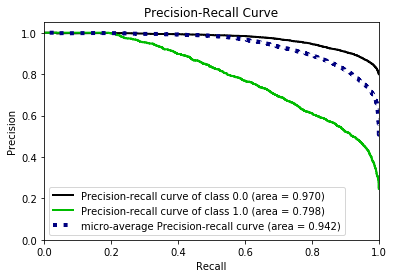

In [9]:
preds = torch.cat(collect).sigmoid().round()
proba = torch.cat(collect)
true = torch.cat(y_true)

proba = torch.stack([1 - proba, proba], dim=1).squeeze()
skplt.metrics.plot_precision_recall_curve(true.detach().cpu().numpy(), 
                                          proba.detach().cpu().numpy())

In [10]:
true.detach().cpu().numpy()

proba.detach().cpu().numpy()

array([[ 4.6316214 , -3.6316211 ],
       [ 4.4578056 , -3.4578056 ],
       [ 0.43854553,  0.5614545 ],
       ...,
       [ 4.1173763 , -3.1173763 ],
       [ 4.3272257 , -3.3272254 ],
       [ 6.326953  , -5.326953  ]], dtype=float32)

In [12]:

def process_train_non_nn(df, cat_columns, num_columns, target):
    cat  = pd.get_dummies(df, columns=cat_columns)
    df = pd.concat([df.drop(cat_columns + ['income'], axis=1), cat], axis=1)

    df_train, df_val = train_test_split(df, train_size=0.8)
    
    target_binarizer = LabelBinarizer()
    df_train[target] = target_binarizer.fit_transform(df_train[target])
    df_val[target] = target_binarizer.transform(df_val[target])

    return df_train, df_val


/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/i008/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

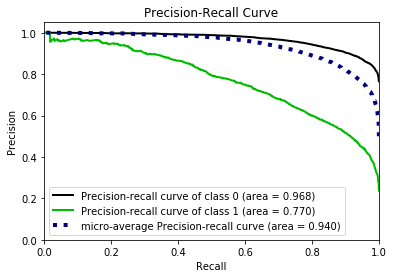

In [15]:
df_train, df_val  = process_train_non_nn(df, cat_columns, num_columns, target)
y_train = df_train.pop('income')
y_test = df_val.pop('income')


rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(df_train,  y_train)

p = rfc.predict(df_val)
pred = rfc.predict_proba(df_val)
skplt.metrics.plot_precision_recall_curve(y_test, pred)